In [ ]:
# !pip install PyYAML

In [1]:
import cv2
import glob
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

C:\Users\Debora\anaconda3\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Debora\anaconda3\envs\py38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Debora\anaconda3\envs\py38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# load YAML
with open('datarefuge.yaml',mode='r') as f:
    data_yaml = yaml.load(f,Loader=SafeLoader)
    
labels = data_yaml['names']
print(labels)

['Disc']


In [3]:
# load YOLO model
yolo = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [4]:
def yolo_detect(path, save):

    saida_dir = "saida_img/"



    # load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_name = img_path.split("\\")[-1][:-4]
    image = img.copy()
    row, col, d = image.shape


    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image
    
    
    INPUT_WH_YOLO = 640
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
    yolo.setInput(blob)
    preds = yolo.forward() # detection or prediction from YOLO


    detections = preds[0]
    boxes = []
    confidences = []
    classes = []

    
    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WH_YOLO
    y_factor = image_h/INPUT_WH_YOLO

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detection 
        if confidence > 0.7:
            class_score = row[5:].max() 
            class_id = row[5:].argmax() 

            if class_score > 0.25:
                cx, cy, w, h = row[0:4]
                # construct bounding 
                left = int((cx - 0.5*w)*x_factor)
                top = int((cy - 0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)

                box = np.array([left,top,width,height])

                # append values into the list
                confidences.append(confidence)
                boxes.append(box)
                classes.append(class_id)

    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    if len(boxes_np) > 0:
        # NMS
        index = np.array( cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten() )
#         print(index)

        # Draw the Bounding
        for ind in index:
            # extract bounding box
            x,y,w,h = boxes_np[ind]
            bb_conf = int(confidences_np[ind]*100)
            classes_id = classes[ind]
            class_name = labels[classes_id]

            text = f'{class_name}: {bb_conf}%'

            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.rectangle(image,(x,y-30),(x+w,y),(255,170,170), -1)

            cv2.putText(image, text,(x,y-10),cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0),2)    

            if save == True:
                if not os.path.exists(saida_dir):
                    os.mkdir(saida_dir)

                roi_image = img[y:y+h,x:x+w]
                cv2.imwrite(saida_dir + img_name + '_' + str(ind) + '.jpg', cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))

    else:
        print("None object found")
        

    plt.imshow(image)
    plt.show()
    
    
    return 


# Images 

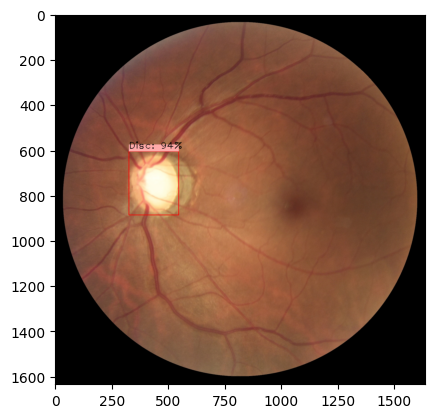

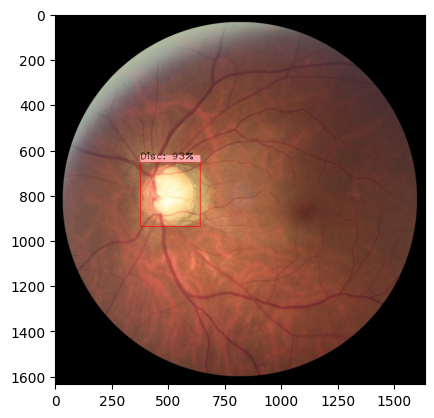

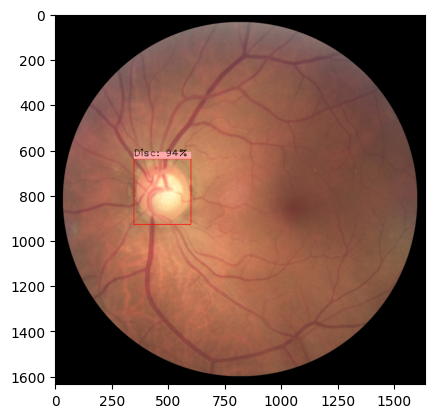

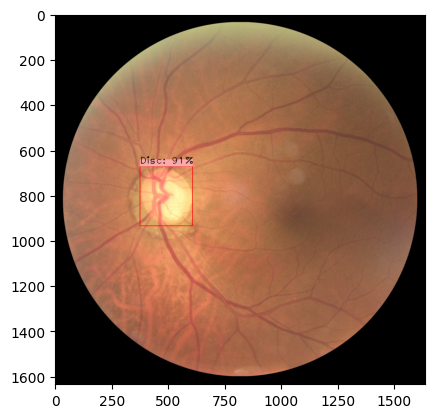

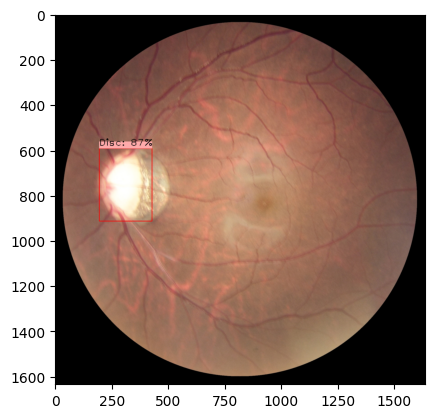

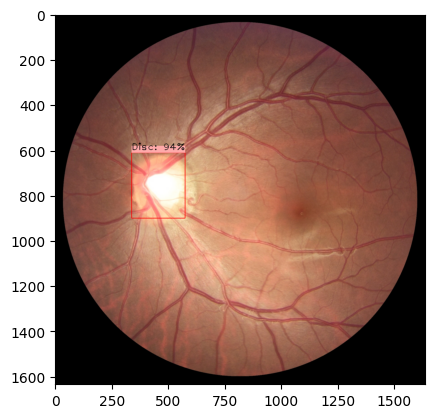

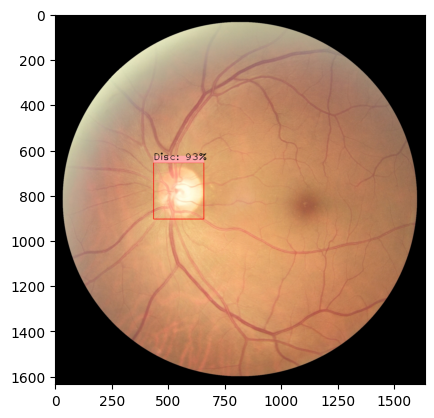

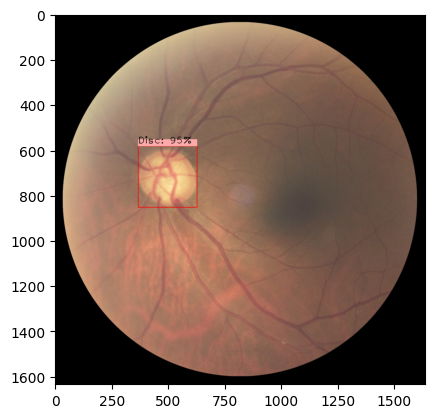


KeyboardInterrupt



In [5]:
path = 'D:/Glaucoma/Banco_de_dados/REFUGE/REFUGE-Test400/Test400/1_glaucoma'
for img_path in glob.glob(path + "/*.jpg"):
    yolo_detect(img_path, save = False) # if save = True, save image of bounding box

# Video

In [ ]:
cap = cv2.VideoCapture('video.mp4')

saida_dir = "saida_video"
i = 0
while True:
    
    ret, frame = cap.read()
    if ret == False:
        print('Error to read video')
        break
        
    try:

        pred_image = yolo.predictions(frame)
    except:
        pass
    cv2.imshow("YOLO v5", cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    
    if save == True:
        
        if not os.path.exists(saida_dir):
            os.mkdir(saida_dir)

    roi_image = img[y:y+h,x:x+w]
    cv2.imwrite(saida_dir + 'image_' + str(i) + '.jpg', cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
    i = i + 1
    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()
cap.release()